## tm_high_order.py

In [1]:
__doc__ = """
Temporal Memoryのいくつかの機能を示す簡単なチュートリアルです。

以下のプログラムは、いくつかの時間記憶の基本的な特性、
特にそれが来るときにはを使用して、高次のシーケンスを
どのように処理するかを確認します。
"""

import numpy as np
import random
random.seed(1)
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from htm.bindings.sdr import SDR
from htm.algorithms import TemporalMemory as TM

%matplotlib inline

print("--------------------------------------------------")
print(__doc__)
print("--------------------------------------------------")

--------------------------------------------------

Temporal Memoryのいくつかの機能を示す簡単なチュートリアルです。

以下のプログラムは、いくつかの時間記憶の基本的な特性、
特にそれが来るときにはを使用して、高次のシーケンスを
どのように処理するかを確認します。

--------------------------------------------------



In [3]:
print("Creating the Temporal Memory")
print("")
tm = TM(
  columnDimensions = (2048,),
  cellsPerColumn=8,
  initialPermanence=0.21,
  connectedPermanence=0.3,
  minThreshold=15,
  maxNewSynapseCount=40,
  permanenceIncrement=0.1,
  permanenceDecrement=0.1,
  activationThreshold=15,
  predictedSegmentDecrement=0.01,
  )
tm.printParameters()

Creating the Temporal Memory

Temporal Memory Parameters
version                   = 2
numColumns                = 2048
cellsPerColumn            = 8
activationThreshold       = 15
initialPermanence         = 0.21
connectedPermanence       = 0.3
minThreshold              = 15
maxNewSynapseCount        = 40
permanenceIncrement       = 0.1
permanenceDecrement       = 0.1
predictedSegmentDecrement = 0.01
maxSegmentsPerCell        = 255
maxSynapsesPerSegment     = 255


In [8]:
print("""
文字 A, B, C, D, X, Y の疎な表現を作成します。
この例では手動で作成していますが、通常は
これらを構築するために空間プーラーを使用します。""")
print("")
sparsity   = 0.02
sparseCols = int(tm.numberOfColumns() * sparsity)
dataset    = {inp : SDR( tm.numberOfColumns() ) for inp in "ABCDXY"}
for i, inp in enumerate("ABCDXY"):
  dataset[inp].dense[ i * sparseCols : (i + 1) * sparseCols ] = 1
  dataset[inp].dense = dataset[inp].dense # この行は、SDR の高密度データが変更されたことを SDR に通知する.
  print("Input", inp, "is bits at indices: [",  i * sparseCols, '-', (i + 1) * sparseCols, ']')

seq1 = "ABCD"
seq2 = "XBCY"
seqT = "ABCDXY"


文字 A, B, C, D, X, Y の疎な表現を作成します。
この例では手動で作成していますが、通常は
これらを構築するために空間プーラーを使用します。

Input A is bits at indices: [ 0 - 40 ]
Input B is bits at indices: [ 40 - 80 ]
Input C is bits at indices: [ 80 - 120 ]
Input D is bits at indices: [ 120 - 160 ]
Input X is bits at indices: [ 160 - 200 ]
Input Y is bits at indices: [ 200 - 240 ]


In [9]:
def trainTM(sequence, iterations, noiseLevel):
  """
  与えられた時間ステップ数と入力の破損レベルに対して，与えられたシーケンスでTMを学習します
  Argument(引数) sequence   (string) 入力文字のシーケンス
  Argument(引数) iterations (int)   TM がシーケンスを提示する時間数
  Argument(引数) noiseLevel (float)  シーケンス内の文字に適用するノイズの量
  Returns x, y
      x is list of timestamps / step numbers
      y is list of prediction accuracy at each step
  """
  ts = 0  
  x = []
  y = []
  for t in range(iterations):
    tm.reset()
    for inp in sequence:
      v = SDR(dataset[inp]).addNoise( noiseLevel )
      tm.compute( v, learn=True)
      x.append(ts)
      y.append( 1 - tm.anomaly )
      ts += 1
  return x, y

In [10]:
def showPredictions():
  """
  A,B,C,D,X,の文字が提示されたときのTMの予測を示しています。
  文脈情報のないY、つまりシーケンス内に埋め込まれていない
  """
  for inp in sorted(dataset.keys()):
    print("--- " + inp + " ---")
    sdr = dataset[inp]
    tm.reset()
    tm.compute( sdr, learn=False)
    tm.activateDendrites(learn=False)
    activeColumnsIndices   = [tm.columnForCell(i) for i in tm.getActiveCells().sparse]
    predictedColumnIndices = [tm.columnForCell(i) for i in tm.getPredictiveCells().sparse]
    print("Active cols: " + str(sorted(set(activeColumnsIndices))))
    print("Predicted cols: " + str(sorted(set(predictedColumnIndices))))
    print("")

In [12]:
print("")
print("--------------------------------------------------")
print("Part 1. TMに配列ABCDを提示する")
print("TMは最終的にシーケンスを学習して、次の文字を予測します")
print("この予測精度は図1の予測精度で測定することができます")
print("注）シーケンスの間では、TMは何も予測を出力しないので")
print("予測精度は0.0である")
print("--------------------------------------------------")
print("")


--------------------------------------------------
Part 1. TMに配列ABCDを提示する
TMは最終的にシーケンスを学習して、次の文字を予測します
この予測精度は図1の予測精度で測定することができます
注）シーケンスの間では、TMは何も予測を出力しないので
予測精度は0.0である
--------------------------------------------------



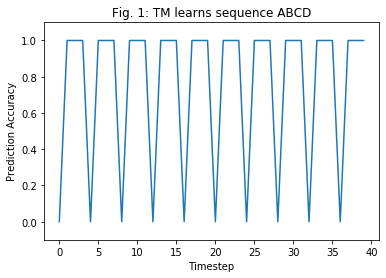


--------------------------------------------------
TMが配列ABCDを学習したら、その予測を知るために個々の文字をTMに提示する
TMは、特定の文字の提示時にアクティブになるカラムと、
次のタイムステップで予測されたカラムを出力する
ここでは、AがBを予測し、BがCを予測し、CがDを予測し、
Dが予測を出力していないことがわかります
注）ここでは，個々の文字，つまり，連続した文脈を持たない文字を提示しています
文字Ｘ、Ｙについては、どのようなシーケンスでもＴＭに提示していないので
予測は出力されない
--------------------------------------------------

--- A ---
Active cols: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39]
Predicted cols: [40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79]

--- B ---
Active cols: [40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79]
Predicted cols: [80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 

In [16]:
x, y = trainTM(seq1, iterations=10, noiseLevel=0.0)

plt.ylim([-0.1,1.1])
plt.plot(x, y)
plt.xlabel("Timestep")
plt.ylabel("Prediction Accuracy")
plt.title("Fig. 1: TM learns sequence ABCD")
#plt.savefig("figure_1")
plt.show()

print("")
print("--------------------------------------------------")
print("TMが配列ABCDを学習したら、その予測を知るために個々の文字をTMに提示する")
print("TMは、特定の文字の提示時にアクティブになるカラムと、")
print("次のタイムステップで予測されたカラムを出力する")
print("ここでは、AがBを予測し、BがCを予測し、CがDを予測し、")
print("Dが予測を出力していないことがわかります")
print("注）ここでは，個々の文字，つまり，連続した文脈を持たない文字を提示しています")
print("文字Ｘ、Ｙについては、どのようなシーケンスでもＴＭに提示していないので")
print("予測は出力されない")
print("--------------------------------------------------")
print("")

showPredictions()

In [17]:
print("")
print("--------------------------------------------------")
print("Part 2. TMにシーケンスXBCYを提示します")
print("予想通り、TMが新しい配列を学習するまでは精度が落ちます（図2）")
print("シーケンスBCが提示された場合、TMの予測はどうなるでしょうか？")
print("これは高次配列の重要な特徴です")
print("--------------------------------------------------")
print("")


--------------------------------------------------
Part 2. TMにシーケンスXBCYを提示します
予想通り、TMが新しい配列を学習するまでは精度が落ちます（図2）
シーケンスBCが提示された場合、TMの予測はどうなるでしょうか？
これは高次配列の重要な特徴です
--------------------------------------------------



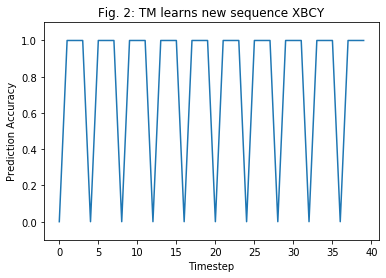


--------------------------------------------------
再度、それぞれの文字を個別にTMに提示する
つまり、2つのシーケンスのいずれかの中ではなく、それぞれの文字を提示する
文字Aが提示されると、TMはBを予測し、BはCを予測しますが
今回はCがDとYの両方を同時に予測して出力します
文字Xが提示されると、TMはBを予測しますが、YとDは予測しません
--------------------------------------------------

--- A ---
Active cols: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39]
Predicted cols: [40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79]

--- B ---
Active cols: [40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79]
Predicted cols: [80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119]

--- C ---
Act

In [22]:
x, y = trainTM(seq2, iterations=10, noiseLevel=0.0)

# この図では、TMがどのようにして特定のキャラクターについて
# 良い予測を立て始めるかを見ることができます(プロットのスパイク)
# しばらくすると、それはシーケンスXBCYを正しく学習し
# それに応じて文字を予測するようになります
plt.ylim([-0.1,1.1])
plt.plot(x, y)
plt.xlabel("Timestep")
plt.ylabel("Prediction Accuracy")
plt.title("Fig. 2: TM learns new sequence XBCY")
#plt.savefig("figure_2")
plt.show()

print("")
print("--------------------------------------------------")
print("再度、それぞれの文字を個別にTMに提示する")
print("つまり、2つのシーケンスのいずれかの中ではなく、それぞれの文字を提示する")
print("文字Aが提示されると、TMはBを予測し、BはCを予測しますが")
print("今回はCがDとYの両方を同時に予測して出力します")
print("文字Xが提示されると、TMはBを予測しますが、YとDは予測しません")
print("--------------------------------------------------")
print("")

showPredictions()


In [23]:
print("")
print("--------------------------------------------------")
print("""Part 3. ここでは、TMにノイズの多い入力を提示します。
TMがノイズの存在に対してどのように反応するか、
またノイズからどのように回復するかを見てみたいと思います。
各文字をエンコードするSDRのビットの30%を破壊することで、
シーケンスXBCYにノイズを追加します。
TMは入力に含まれるランダムなノイズを学習できないため、
予測精度が低下すると予想されます（図3）。
しかし、この予測精度の低下は大きなものではない。""")
print("--------------------------------------------------")
print("")


--------------------------------------------------
Part 3. ここでは、TMにノイズの多い入力を提示します。
TMがノイズの存在に対してどのように反応するか、
またノイズからどのように回復するかを見てみたいと思います。
各文字をエンコードするSDRのビットの30%を破壊することで、
シーケンスXBCYにノイズを追加します。
TMは入力に含まれるランダムなノイズを学習できないため、
予測精度が低下すると予想されます（図3）。
しかし、この予測精度の低下は大きなものではない。
--------------------------------------------------



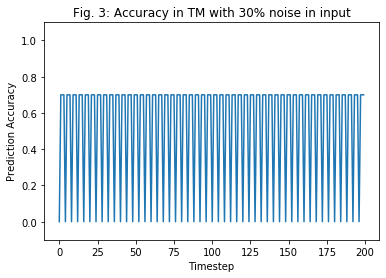


--------------------------------------------------
ノイズの多い入力(30%)を与えられたときのTMの出力をもう一度見てみましょう
ここでは、ノイズはTMがその影響を受けない程度に低いですが
個々の文字が提示されたときに「ノイズの多い」カラムが
予測されているのを見た場合のようになります
このように、TMは入力のノイズに対して回復力を示していると言えるでしょう
--------------------------------------------------

--- A ---
Active cols: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39]
Predicted cols: [40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79]

--- B ---
Active cols: [40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79]
Predicted cols: [80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119]

--- C 

In [25]:
x, y = trainTM(seq2, iterations=50, noiseLevel=0.3)

plt.ylim([-0.1,1.1])
plt.plot(x, y)
plt.xlabel("Timestep")
plt.ylabel("Prediction Accuracy")
plt.title("Fig. 3: Accuracy in TM with 30% noise in input")
#plt.savefig("figure_3")
plt.show()

print("")
print("--------------------------------------------------")
print("ノイズの多い入力(30%)を与えられたときのTMの出力をもう一度見てみましょう")
print("ここでは、ノイズはTMがその影響を受けない程度に低いですが")
print("個々の文字が提示されたときに「ノイズの多い」カラムが")
print("予測されているのを見た場合のようになります")
print("このように、TMは入力のノイズに対して回復力を示していると言えるでしょう")
print("--------------------------------------------------")
print("")

showPredictions()


--------------------------------------------------
今度は、文字のビット数の60%までノイズを増やしていきます
予想通り、予測精度は低下し（図4）
「ノイズの多い」カラムはTMによって予測されます
--------------------------------------------------



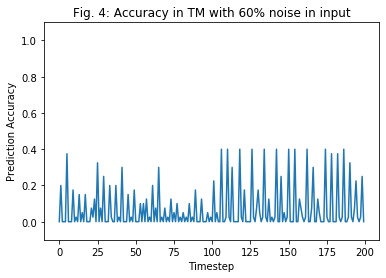

In [27]:
print("")
print("--------------------------------------------------")
print("今度は、文字のビット数の60%までノイズを増やしていきます")
print("予想通り、予測精度は低下し（図4）")
print("「ノイズの多い」カラムはTMによって予測されます")
print("--------------------------------------------------")
print("")

x, y = trainTM(seq2, iterations=50, noiseLevel=0.6)

plt.ylim([-0.1,1.1])
plt.plot(x, y)
plt.xlabel("Timestep")
plt.ylabel("Prediction Accuracy")
plt.title("Fig. 4: Accuracy in TM with 60% noise in input")
#plt.savefig("figure_4")
plt.show()


--------------------------------------------------
破損していない配列XBCYをTMに提示した後、
前のステップで予測されたノイズの多い列が消え、
予測精度が正常に戻ることを期待します。(図5)
--------------------------------------------------



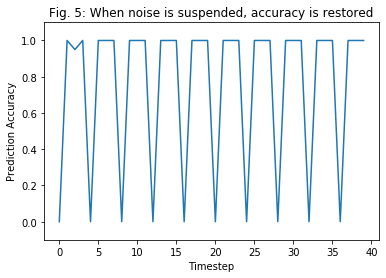

In [28]:
# TMは前のステップで学習した'noisy'カラムを忘れることができるでしょうか？
# TMに元の配列XBCYを提示して, 「ノイズの多い」カラムを忘れるようにします

print("")
print("--------------------------------------------------")
print("""破損していない配列XBCYをTMに提示した後、
前のステップで予測されたノイズの多い列が消え、
予測精度が正常に戻ることを期待します。(図5)""")
print("--------------------------------------------------")
print("")

x, y = trainTM(seq2, iterations=10, noiseLevel=0.0)

plt.ylim([-0.1,1.1])
plt.plot(x, y)
plt.xlabel("Timestep")
plt.ylabel("Prediction Accuracy")
plt.title("Fig. 5: When noise is suspended, accuracy is restored")
#plt.savefig("figure_5")
plt.show()

In [30]:
print("")
print("--------------------------------------------------")
print("""Part 4. TMに対して、ABCDとXBCYの両方の配列をランダムに提示する
ここでは、TMがD, Y, Cの文字で提示されたときに同時予測が発生する可能性があります
注意）ここでは、各シーケンスを提示した後にTMをリセットすることはありません
ここでは、TMにDとYの異なる予測を学習させる目的で、各シーケンスを提示した後に
TMをリセットしない""")
print("--------------------------------------------------")
print("")


--------------------------------------------------
Part 4. TMに対して、ABCDとXBCYの両方の配列をランダムに提示する
ここでは、TMがD, Y, Cの文字で提示されたときに同時予測が発生する可能性があります
注意）ここでは、各シーケンスを提示した後にTMをリセットすることはありません
ここでは、TMにDとYの異なる予測を学習させる目的で、各シーケンスを提示した後に
TMをリセットしない
--------------------------------------------------



In [32]:
tm = TM(columnDimensions = (2048,),
  cellsPerColumn=8,
  initialPermanence=0.21,
  connectedPermanence=0.3,
  minThreshold=15,
  maxNewSynapseCount=40,
  permanenceIncrement=0.1,
  permanenceDecrement=0.1,
  activationThreshold=15,
  predictedSegmentDecrement=0.01,
  )

for t in range(75):
  seq = random.choice([ seq1, seq2 ])
  for inp in seq:
    tm.compute( dataset[inp], learn=True)

print("")
print("--------------------------------------------------")
print("ここで、個々の文字 A、B、C、D、X、および Y を提示したときの")
print("TM の出力を見てみましょう")
print("文字 D (A と X を予測)、文字 Y (A と X を予測)、文字 C (D と Y を予測) ")
print("が提示されたときに、同時に予測が行われていることがわかります.")
print("--------------------------------------------------")
print("")

showPredictions()


--------------------------------------------------
ここで、個々の文字 A、B、C、D、X、および Y を提示したときの
TM の出力を見てみましょう
文字 D (A と X を予測)、文字 Y (A と X を予測)、文字 C (D と Y を予測) 
が提示されたときに、同時に予測が行われていることがわかります.
--------------------------------------------------

--- A ---
Active cols: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39]
Predicted cols: [40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79]

--- B ---
Active cols: [40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79]
Predicted cols: [80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119]

--- C ---
Active cols: [80, 